# Bear Spring EPM (Equivalent Porous Media) Model

Model started 10/14/24 by Charles Soucey. Modeled after Langevin, C. 2024, UMN Hydrocamp  
[Link to Reference Code](https://github.com/langevin-usgs/umn2024/tree/main)

Iterated and updated by Jenny Huang.

In [1]:
# import python packages
import pathlib as pl #Pathlib used for switching between directories, accessing files
import numpy as np #for numerical operations
import matplotlib.pyplot as plt #for creating plots
from matplotlib.ticker import FormatStrFormatter
 
import pandas as pd #for handling dataframes
import flopy #Used for interacting with MODFLOW, developing MODFLOW inputs and reading outputs
import rasterio #For working with raster data and shapefiles
from rasterio import features
import geopandas as gpd #For importing shapefiles
import shapely as shp
import networkx as nx
import geojson
import os
import sys
import importlib
import yaml
import seaborn as sns


In [2]:
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "../../src"))) #use this to be able to import local packages

In [38]:
import utils.utils
import utils.config
import utils.creeks
import utils.calibration
importlib.reload(utils.utils)
importlib.reload(utils.config)
importlib.reload(utils.creeks)
importlib.reload(utils.calibration)
from utils.config import *
from utils.utils import *
from utils.creeks import *
from utils.calibration import * 

new config loaded from EPM_2layer_transient.yaml
loaded watershed geojson
loaded springshed geojson
loaded creeks geojson
loaded subdomain geojson
loaded karst_features csv
loaded sinkholes csv
loaded precip csv
loaded recharge csv
extracted watershed polygon
extracted springshed polygon
extracted subdomain polygon
merged ('watershed_polygon', 'springshed_polygon')
loaded new Creek object from creeks data
set domain to subdomain_polygon
(552594.40655525, 4866235.880722723, 561054.4101949929, 4870845.335745172)
applied DEM ../../data/DEM/dem_1m_m.bil to domain
converted start tuple to Point
added segment from POINT (557455.9219013986 4866985.336331408) to POINT (557644.4070525824 4866235.880722723)

converted start tuple to Point
added segment from POINT (560184.9218932291 4868831.33646198) to POINT (560584.4090987638 4869035.8773543835)

clipped creeks
added sink
added spring
extracted grid params: 
Lx = 8460.003639742848
Ly = 4609.455022448674
nrow = 184
ncol = 338
nlay = 2
set top to

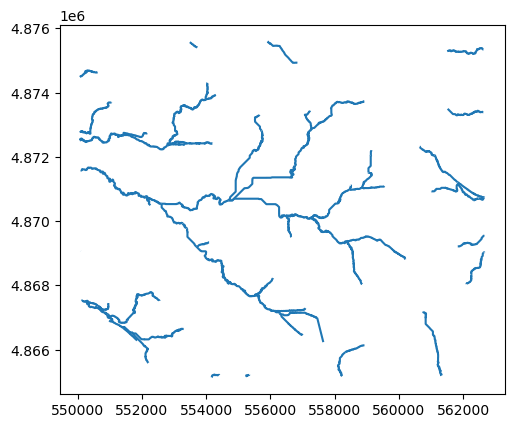

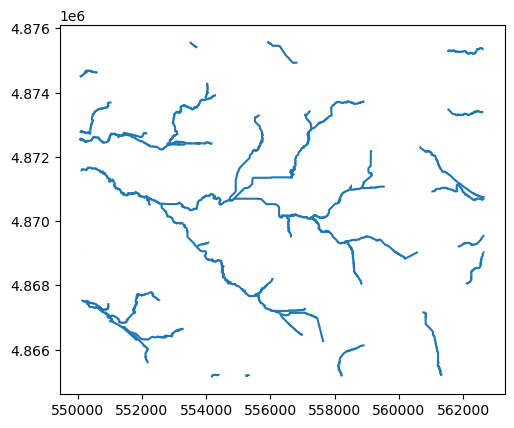

In [39]:
test = Config('EPM_2layer_transient.yaml')
test.load_polygon('watershed', 'springshed', 'subdomain')
test.merge_polygons('merged', 'watershed_polygon', 'springshed_polygon')
test.load_creeks()
test.set_domain('subdomain_polygon')
test.apply_DEM_to_domain()
start = test.creeks.return_coordinates(186)[-1]
nearest = get_nearest_point(start, test.merged_polygon)
test.creeks.extend_creek(start, nearest)
start = test.creeks.return_coordinates(154)[-1]
nearest = get_nearest_point(start, test.merged_polygon)
test.creeks.extend_creek(start, nearest)
test.creeks.clip_creek(test.domain, 10)
test.load_karst_features()
test.extract_grid_params_from_domain()
test.extract_top_config()
test.extract_bottom_config()
test.create_grid()
test.extract_idomain()
test.extract_K_values()
test.extract_creek_cells()
springshed_cells = test.extract_polygon_cells(test.springshed_polygon)
springshed_top = np.hstack([np.zeros((springshed_cells.shape[0], 1)), springshed_cells])
springshed_botm = np.hstack([np.ones((springshed_cells.shape[0], 1)), springshed_cells])
test.set_K_values(springshed_top, Kh = test.Kh_ss[0], Kv = test.Kv_ss[0])
test.set_K_values(springshed_botm, Kh = test.Kh_ss[1], Kv = test.Kv_ss[1])

c:\Users\huan1428\Documents\karst\UMNBearSpring\src\utils\config.py:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)


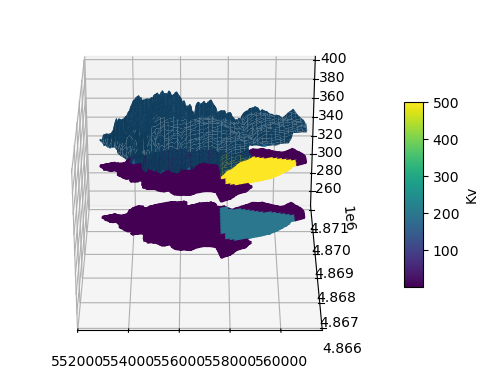

In [40]:
test.plot_model_grid_layers(test.Kv_vals, azim = 270, elev = 30, cmap = 'viridis', var_name = 'Kv')
# plt.savefig('../../../figs/multilayer_domain.png', bbox_inches = 'tight')

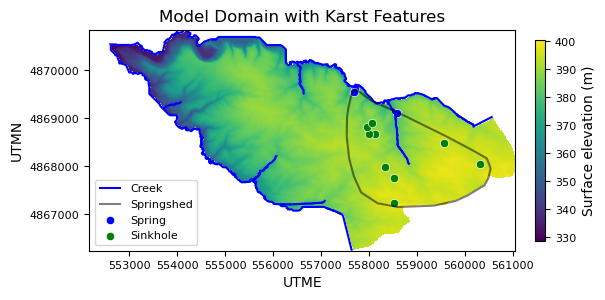

In [22]:
fig, ax = plt.subplots()
plt.imshow(np.ma.masked_where(test.idomain[0] == 0, test.dem_grid), extent = [test.total_bounds[0], test.total_bounds[2], test.total_bounds[1], test.total_bounds[3]])
colorbar = plt.colorbar(label = 'Surface elevation (m)', shrink = 0.5, fraction=0.1, pad=0.04)
colorbar.ax.set_position([0.85, 0.01, 0.05, 0.7])  # [left, bottom, width, height]

colorbar.ax.tick_params(labelsize = 8)
test.creeks.plot(ax = ax, label = 'Creek', color = 'blue')
test.plot_polygons('springshed_polygon', boundary = True, color = 'black', ax= ax, alpha= 0.5, label = 'Springshed')
test.domain.boundary.plot(ax = ax, alpha = 1, color = 'black')

sns.scatterplot(test.spring,x = 'UTME', y = 'UTMN', color = 'blue', label = 'Spring')
sns.scatterplot(test.sink,x = 'UTME', y = 'UTMN', color = 'green', label = 'Sinkhole' )
plt.title('Model Domain with Karst Features')
plt.xticks(fontsize = 8)
plt.yticks(fontsize = 8)

ax.xaxis.set_major_formatter(FormatStrFormatter('%1.6s'))
ax.yaxis.set_major_formatter(FormatStrFormatter('%1.7s'))
plt.legend(loc='lower left', bbox_to_anchor=(0,0), fontsize = 8)
plt.tight_layout()

plt.savefig('../../../figs/dem_model_domain.png', bbox_inches = 'tight', transparent = True)


In [41]:
test.recharge = test.recharge['RCH[m/day]']

In [42]:
test.extract_recharge()

{0: 0.000725545,
 1: 0.000721654,
 2: 0.000717757,
 3: 0.000713857,
 4: 0.000709957,
 5: 0.000706063,
 6: 0.000702179,
 7: 0.000698707,
 8: 0.00069557,
 9: 0.000692418,
 10: 0.000688349,
 11: 0.001374106,
 12: 0.000752159,
 13: 0.00071444,
 14: 0.000697244,
 15: 0.000686033,
 16: 0.000680428,
 17: 0.000676171,
 18: 0.000748515,
 19: 0.000759446,
 20: 0.000712367,
 21: 0.000688883,
 22: 0.004588147,
 23: 0.001593055,
 24: 0.001126994,
 25: 0.001022069,
 26: 0.000988856,
 27: 0.000891654,
 28: 0.000881858,
 29: 0.000855364,
 30: 0.000848501,
 31: 0.000825264,
 32: 0.000780599,
 33: 0.000773915,
 34: 0.000751061,
 35: 0.000745598,
 36: 0.000740568,
 37: 0.000733339,
 38: 0.000722258,
 39: 0.00071757,
 40: 0.00070259,
 41: 0.000688864,
 42: 0.000683999,
 43: 0.000679102,
 44: 0.000675666,
 45: 0.000685772,
 46: 0.000677366,
 47: 0.000651839,
 48: 0.000645216,
 49: 0.000662343,
 50: 0.000649378,
 51: 0.00063242,
 52: 0.000632484,
 53: 0.000625454,
 54: 0.000621088,
 55: 0.00081936,
 56: 0.0

In [43]:
# row = test.creek_cells[:,0]
# col = test.creek_cells[:,1]
# lay = 0
# elev = test.get_cell_elev(row, col)
# C = 400 #m/d
drn_spd = test.extract_drain_spd()
test.make_sim(lenuni = "METER", ws = 'model_runs/EPM_transient')
test.add_npf_module()
test.add_recharge_module()
test.add_drains_module()

added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 365 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = {0: 0.000725545, 1: 0.000721654, 2: 0.000717757, 3: 0.000713857, 4: 0.000709957, 5: 0.000706063, 6: 0.000702179, 7: 0.000698707, 8: 0.00069557, 9: 0.000692418, 10: 0.000688349, 11: 0.001374106, 12: 0.000752159, 13: 0.00071444, 14: 0.000697244, 15: 0.000686033, 16: 0.000680428, 17: 0.000676171, 18: 0.000748515, 19: 0.000759446, 20: 0.000712367, 21: 0.000688883, 22: 0.004588147, 23: 0.001593055, 24: 0.001126994, 25: 0.001022069, 26: 0.000988856, 27: 0.000891654, 28: 0.000881858, 29: 0.000855364, 30: 0.000848501, 31: 0.000825264, 32: 0.000780599, 33: 0.000773915, 34: 0.000751061, 35: 0.000745598, 36: 0.000740568, 37: 0.000733339, 38: 0.000722258, 39: 0.00071757, 40: 0.00070259

package_name = drn_0
filename = EPM_transient.drn
package_type = drn
model_or_simulation_package = model
model_name = EPM_transient

Block options
--------------------
print_flows
{internal}
(True)

save_flows
{internal}
(True)


Block period
--------------------
stress_period_data
{internal}
(      cellid_layer  cellid_row  cellid_column        elev  cond
0                0           0             61  335.851227    10
1                0           0             62  336.119629    10
2                0           0             63  335.969788    10
3                0           0             64  335.969971    10
4                0           0             65  336.135437    10
...            ...         ...            ...         ...   ...
1227             0         182            201  389.697998    10
1228             0         183            201  389.503357    10
1229             0          49            205  374.240631   100
1230             0          51            204  378.211090   100
1

In [44]:
test.run_sim()

writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_transient...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 1232 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\..\modflow\mf6.5.0_win64par\bin\mf6.exe
                               MODFLOW 6 EXTENDED
                U.S. GEOLOGICAL SURVEY MODULAR HYDROLOGIC MODEL
                            VERSION 6.5.0 05/23/2024

   MODFLOW 6 compiled May 23 2024 18:08:14 with Intel(R) Fortran Intel(R) 64
  Compiler Classic for applications running on Intel(R) 64, Version 2021.11.1
                             Build 20231117_000000

This software has been approved for release by th

(True, [])

In [45]:
test.load_sim()
test.load_model()
test.read_head_output(totim = 3)
test.read_drain_discharge_output(totim = 3)

loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package rch...
    loading package drn...
  loading solution package epm_transient...
simulation model_runs/EPM_transient loaded
model EPM_transient loaded
heads data read to heads
read drain discharge to drain_spd and drain_array


(             cellid        elev  cond         dis
 0        (0, 0, 61)  335.851227    10  -21.223885
 1        (0, 0, 62)  336.119629    10  -18.924982
 2        (0, 0, 63)  335.969788    10  -20.319315
 3        (0, 0, 64)  335.969971    10  -19.780694
 4        (0, 0, 65)  336.135437    10  -17.152553
 ...             ...         ...   ...         ...
 1227  (0, 182, 201)  389.697998    10    0.000000
 1228  (0, 183, 201)  389.503357    10    0.000000
 1229   (0, 49, 205)  374.240631   100 -239.803106
 1230   (0, 51, 204)  378.211090   100    0.000000
 1231   (0, 69, 240)  382.051453   100    0.000000
 
 [1232 rows x 4 columns],
 array([[[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]],
 
        [[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., .

array([[[1.e+30, 1.e+30, 1.e+30, ..., 1.e+30, 1.e+30, 1.e+30],
        [1.e+30, 1.e+30, 1.e+30, ..., 1.e+30, 1.e+30, 1.e+30],
        [1.e+30, 1.e+30, 1.e+30, ..., 1.e+30, 1.e+30, 1.e+30],
        ...,
        [1.e+30, 1.e+30, 1.e+30, ..., 1.e+30, 1.e+30, 1.e+30],
        [1.e+30, 1.e+30, 1.e+30, ..., 1.e+30, 1.e+30, 1.e+30],
        [1.e+30, 1.e+30, 1.e+30, ..., 1.e+30, 1.e+30, 1.e+30]],

       [[1.e+30, 1.e+30, 1.e+30, ..., 1.e+30, 1.e+30, 1.e+30],
        [1.e+30, 1.e+30, 1.e+30, ..., 1.e+30, 1.e+30, 1.e+30],
        [1.e+30, 1.e+30, 1.e+30, ..., 1.e+30, 1.e+30, 1.e+30],
        ...,
        [1.e+30, 1.e+30, 1.e+30, ..., 1.e+30, 1.e+30, 1.e+30],
        [1.e+30, 1.e+30, 1.e+30, ..., 1.e+30, 1.e+30, 1.e+30],
        [1.e+30, 1.e+30, 1.e+30, ..., 1.e+30, 1.e+30, 1.e+30]]])

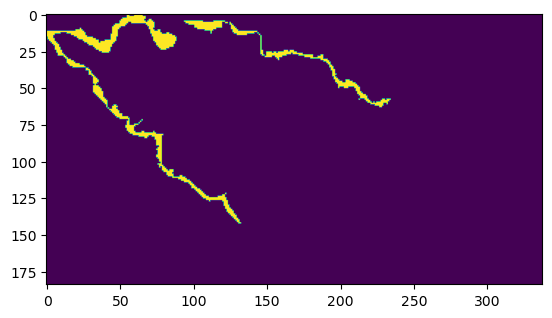

In [46]:
plt.imshow(test.check_head_above_land_surface('bool'))

c:\Users\huan1428\Documents\karst\UMNBearSpring\src\utils\config.py:188: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)


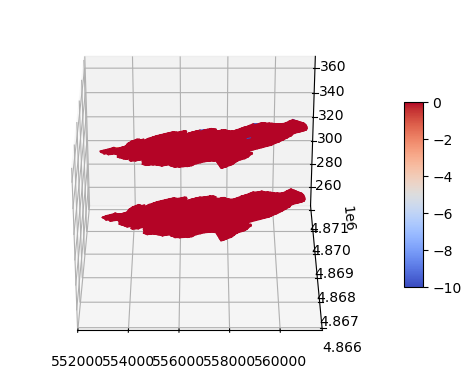

In [38]:
test.plot_model_grid_layers(test.drain_array, azim = 270, show_surface = False, cmap = 'coolwarm', vmin = -10)

<Axes: xlabel='UTME', ylabel='UTMN'>

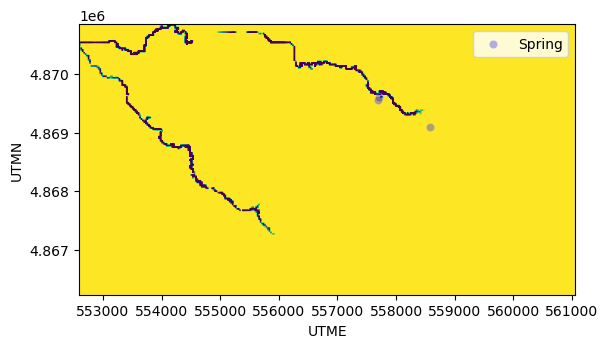

In [47]:
plt.imshow(test.drain_array[0], vmin = -10, vmax = 0, cmap = 'viridis', extent = [test.total_bounds[0], test.total_bounds[2], test.total_bounds[1], test.total_bounds[3]])
sns.scatterplot(test.spring,x = 'UTME', y = 'UTMN', color = 'blue', label = 'Spring', alpha = 0.3)



In [34]:
model = test.sim.get_model('EPM_steady_state')
heads = model.output.head().get_data(idx = 0)
heads[heads > 1e10] = np.nan

c:\Users\huan1428\Documents\karst\UMNBearSpring\src\utils\config.py:189: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)


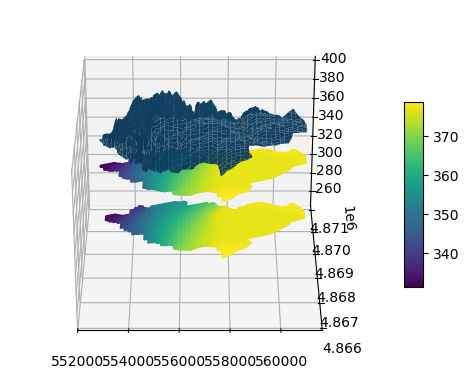

In [48]:
test.plot_model_grid_layers(test.heads, azim = 270)

c:\Users\huan1428\Documents\karst\UMNBearSpring\src\utils\config.py:184: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap_func = plt.cm.get_cmap(cmap)


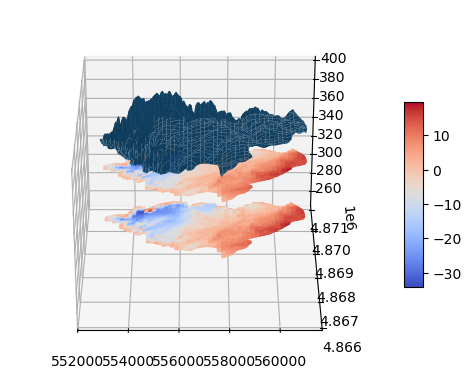

In [37]:
test.plot_model_grid_layers(heads - test.dem_grid, azim = 270, cmap = 'coolwarm')

## Calibration
- objective function:
    - compare MRSW head value
    - check for head above land surface
        - need to aggregate 
    - check head below bottom cell
        - also need to aggregate
    - check BS discharge (avg baseflow)
- methods needed
    - check_head(cell, true_val)
    - check_head_above_surface(heads, surface_elev):
    - check_discharge(cellid, true_val)
- variables to adjust:
    - C_creek
    - C_spring
    - Kh_1
    - Kh_2
    - Kv_1
    - Kv_2
- inverse modeling thing where I run a bunch of simulations with different permutations of the parameters 
- then I evaluate based on the objective function




In [49]:
mrsw = CalibrationData(name = 'mrsw', filename = '../../data/MRSW/MRSW_head_CSV.csv', UTME = 557091, UTMN = 4867265)
mrsw.convert_data_to_timeseries()

read ../../data/MRSW/MRSW_head_CSV.csv and set data
calibration obj mrsw created
updated data to time series


In [50]:
bs_q = CalibrationData(name = 'bs_q', filename = '../../data/discharge/discharge_2017_2020.csv')
bs_q.convert_data_to_timeseries(datetime_col='date')

read ../../data/discharge/discharge_2017_2020.csv and set data
calibration obj bs_q created


c:\Users\huan1428\Documents\karst\UMNBearSpring\src\utils\utils.py:138: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col])


updated data to time series


In [53]:
bs_q.data['m3/d'] = bs_q.data['Q [m3/s]'] * 86400
bs_q.data.to_csv('../../data/discharge/discharge_2017_2020.csv')

In [ ]:
bs_q.set_cal_value(bs_q.data.rolling(window = '7D').mean().mean()['m3/d'])
bs_UTME, bs_UTMN = run.spring[run.spring.ID == '55A00572'].UTME.iloc[0], run.spring[run.spring.ID == '55A00572'].UTMN.iloc[0]
bs_cell_idx = run.get_cell_id_from_coords(bs_UTME, bs_UTMN)

calibration value set to 0.06633395258117701


In [74]:
bud = test.model.output.budget() #read budget
drain_dis = bud.get_data(text='DRN')[0]
drain_id = [id - 1 for (row, id, dis) in drain_dis] #get cell ids, subtract one to convert to 0-based indexing
dis = [dis for (row, id, dis) in drain_dis] #get discharge values
test.drain_spd.loc[drain_id,'dis'] = dis #append discharge to corresponding drains by ID 


In [78]:
test.drain_spd

,cellid,elev,cond,dis
0,"(0, 0, 309)",334.819733,10,-7.911813
1,"(0, 0, 310)",334.908783,10,-7.377648
2,"(0, 0, 311)",335.247498,10,-4.526894
3,"(0, 0, 312)",335.595551,10,-1.510860
4,"(0, 0, 313)",335.667847,10,-0.948252
...,...,...,...,...
6447,"(0, 919, 1009)",389.455933,10,-16.995515
6448,"(0, 920, 1009)",389.506226,10,-16.476644
6449,"(0, 247, 1024)",373.009979,100,-0.147621
6450,"(0, 258, 1019)",376.582642,100,0.000000


In [59]:
mrsw.set_cal_value(mrsw.data['gw_elev[m]'].mean())

calibration value set to 345.7397551152074


In [60]:
mrsw_cell_idx = test.get_cell_id_from_coords(mrsw.UTME, mrsw.UTMN)
mrsw.get_residual(test.heads[0][mrsw_cell_idx])

38.68113527265996

<Axes: >

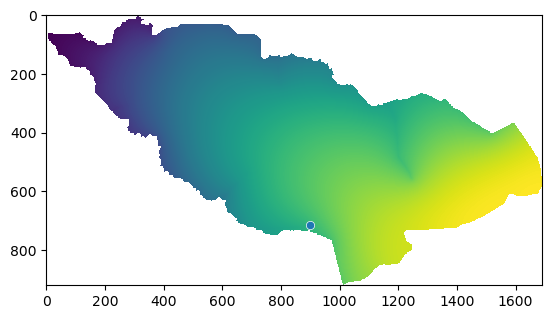

In [55]:
plt.imshow(test.heads[0], cmap = 'viridis') #, extent = [test.total_bounds[0], test.total_bounds[2], test.total_bounds[1], test.total_bounds[3]])
sns.scatterplot(x = [mrsw_cell_idx[1]], y = [mrsw_cell_idx[0]])
# sns.scatterplot(x = [mrsw.UTME], y = [mrsw.UTMN])


# Grid Search

In [6]:
from itertools import product

In [7]:
#calibration loop
#iterate through param space
param_space = {
    'Kh_0' : list(np.arange(0, 110, 10)),
    'Kh_1' : list(np.arange(0.1, 10.1, 0.1)),
    'Kv_0' : list(np.arange(0.1, 10.1, 0.1)),
    'Kv_1' : list(np.arange(0.1, 10.1, 0.1)),
    'C_spring' : list(np.arange(10, 110, 10)),
    'C_creek' : list(np.arange(.1, 1.1, .1)),
}

values = list(param_space.values())
keys = list(param_space.keys())
filtered_combos = (
    combo for combo in (
        dict(zip(keys, values))
        for values in product(*values)
    )
    
)
size = 10
rank = 1

combo_gen = (
    combo
    for i, vals in enumerate(product(*values))
    if (i % size == rank)
    and (lambda combo: combo['Kh_1'] <= combo['Kh_0'] and combo['Kv_1'] <= combo['Kv_0'] and combo['C_spring'] >= combo['C_creek'])(dict(zip(keys, vals)))
    # returns the dict only if it passes the condition
    for combo in [dict(zip(keys, vals))]
)

#write yaml file
#run model

new config loaded from EPM_2layer.yaml
loaded watershed geojson
loaded springshed geojson
loaded creeks geojson
loaded subdomain geojson
loaded karst_features csv
loaded sinkholes csv
loaded precip csv
extracted watershed polygon
extracted springshed polygon
extracted subdomain polygon
merged ('watershed_polygon', 'springshed_polygon')
loaded new Creek object from creeks data
set domain to subdomain_polygon
(552594.40655525, 4866235.880722723, 561054.4101949929, 4870845.335745172)
applied DEM ../../data/DEM/dem_1m_m.bil to domain
converted start tuple to Point
added segment from POINT (557455.9219013986 4866985.336331408) to POINT (557644.4070525824 4866235.880722723)

converted start tuple to Point
added segment from POINT (560184.9218932291 4868831.33646198) to POINT (560584.4090987638 4869035.8773543835)

clipped creeks
added sink
added spring
extracted grid params: 
Lx = 8460.003639742848
Ly = 4609.455022448674
nrow = 921
ncol = 1692
nlay = 2
set top to DEM
set bottom array
updated

0it [00:00, ?it/s]

extracted K values
added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 1 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = 0.0038
drains added
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following executable to run the model: ..\..\..\..\..\..\modflow\mf6.5.0_win64par\bin\mf6.exe
                               MODFLOW 6 EXTENDED
                

1it [04:05, 245.24s/it]

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/06/22 20:32:07
 Elapsed run time:  2 Minutes, 46.120 Seconds
 
 Normal termination of simulation.
extracted K values
added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 1 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = 0.0038
drains added
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following

2it [08:12, 246.16s/it]

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/06/22 20:36:14
 Elapsed run time:  2 Minutes, 50.808 Seconds
 
 Normal termination of simulation.
extracted K values
added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 1 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = 0.0038
drains added
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following

3it [34:52, 864.72s/it]

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/06/22 21:02:55
 Elapsed run time:  3 Minutes, 32.848 Seconds
 
 Normal termination of simulation.
extracted K values
added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 1 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = 0.0038
drains added
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following

4it [40:44, 662.05s/it]

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/06/22 21:08:46
 Elapsed run time:  4 Minutes,  5.652 Seconds
 
 Normal termination of simulation.
extracted K values
added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 1 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = 0.0038
drains added
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following

5it [45:10, 519.27s/it]

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/06/22 21:13:12
 Elapsed run time:  3 Minutes,  9.274 Seconds
 
 Normal termination of simulation.
extracted K values
added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 1 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = 0.0038
drains added
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following

6it [49:26, 429.83s/it]

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/06/22 21:17:28
 Elapsed run time:  2 Minutes, 58.186 Seconds
 
 Normal termination of simulation.
extracted K values
added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 1 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = 0.0038
drains added
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following

7it [53:49, 375.28s/it]

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/06/22 21:21:51
 Elapsed run time:  3 Minutes,  7.300 Seconds
 
 Normal termination of simulation.
extracted K values
added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 1 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = 0.0038
drains added
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following

8it [58:11, 339.24s/it]

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/06/22 21:26:13
 Elapsed run time:  3 Minutes,  4.700 Seconds
 
 Normal termination of simulation.
extracted K values
added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 1 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = 0.0038
drains added
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following

9it [1:02:23, 311.90s/it]

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/06/22 21:30:25
 Elapsed run time:  2 Minutes, 53.296 Seconds
 
 Normal termination of simulation.
extracted K values
added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 1 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = 0.0038
drains added
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following

10it [1:06:26, 290.60s/it]

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/06/22 21:34:28
 Elapsed run time:  2 Minutes, 46.934 Seconds
 
 Normal termination of simulation.
extracted K values
added creeks to drain spd
added springs to drain spd
simulation created
time discretization added. 1 periods with 1 DAYS
iterative model solver added
gwf module added
discretization added
water table set with dtw = 1.58
set initial conditions
output control added
npf module created
recharge module created with r = 0.0038
drains added
writing simulation...
  writing simulation name file...
  writing simulation tdis package...
  writing solution package ims...
  writing model EPM_steady_state...
    writing model name file...
    writing package dis...
    writing package ic...
    writing package oc...
    writing package npf...
    writing package rcha_0...
    writing package drn_0...
INFORMATION: maxbound in ('gwf6', 'drn', 'dimensions') changed to 6452 based on size of stress_period_data
FloPy is using the following

11it [1:10:13, 383.03s/it]

 
 Run end date and time (yyyy/mm/dd hh:mm:ss): 2025/06/22 21:38:15
 Elapsed run time:  2 Minutes, 32.673 Seconds
 
 Normal termination of simulation.


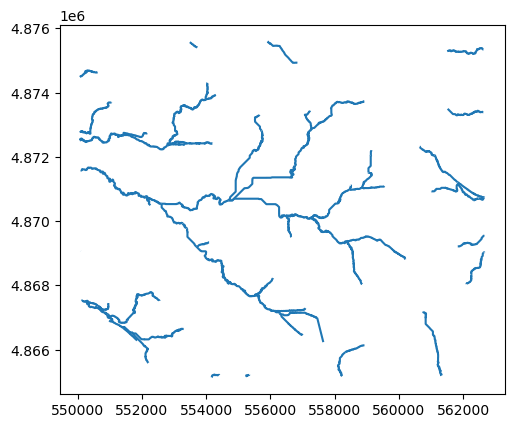

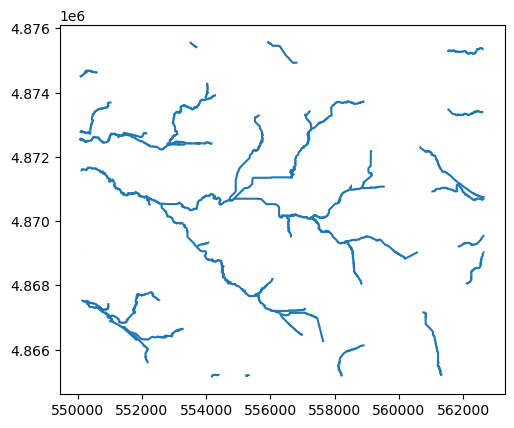

In [ ]:
from tqdm import tqdm
i = 0 
run = Config('EPM_2layer.yaml')
run.load_polygon('watershed', 'springshed', 'subdomain')
run.merge_polygons('merged', 'watershed_polygon', 'springshed_polygon')
run.load_creeks()
run.set_domain('subdomain_polygon')
run.apply_DEM_to_domain()
start = run.creeks.return_coordinates(186)[-1]
nearest = get_nearest_point(start, run.merged_polygon)
run.creeks.extend_creek(start, nearest)
start = run.creeks.return_coordinates(154)[-1]
nearest = get_nearest_point(start, run.merged_polygon)
run.creeks.extend_creek(start, nearest)
run.creeks.clip_creek(run.domain, 10)
run.load_karst_features()
run.extract_grid_params_from_domain()
run.extract_top_config()
run.extract_bottom_config()
run.create_grid()
run.extract_idomain()
run.extract_creek_cells()
#calibration data 
mrsw = CalibrationData(name = 'mrsw', filename = '../../data/MRSW/MRSW_head_CSV.csv', UTME = 557091, UTMN = 4867265)
bs_q = CalibrationData(name = 'bs_q', filename = '../../data/discharge/discharge_2017_2020.csv')

mrsw.convert_data_to_timeseries()
bs_q.convert_data_to_timeseries(datetime_col='date')

mrsw.set_cal_value(mrsw.data['gw_elev[m]'].mean())
bs_q.set_cal_value(bs_q.data.rolling(window = '7D').mean().mean()['Q [m3/s]'])

mrsw_cell_idx = run.get_cell_id_from_coords(mrsw.UTME, mrsw.UTMN)
bs_UTME, bs_UTMN = run.spring[run.spring.ID == '55A00572'].UTME, run.spring[run.spring.ID == '55A00572'].UTMN
bs_cell_idx = run.get_cell_id_from_coords(bs_UTME, bs_UTMN)

#run performance tracking 
run_data = pd.DataFrame(columns = keys + ['success', 'mrsw_head', 'mrsw_error', 'bs_q', 'bs_error', 'head_above_surface_error'])


In [ ]:
max_runs = 5
i = 0
for combo in tqdm(combo_gen):
    run_name = f'EPM_2layer/creeks_{combo["C_creek"]}_springs_{combo["C_spring"]}_Kh_{combo["Kh_0"]}_{combo["Kh_1"]}_Kv_{combo["Kv_0"]}_{combo['Kv_1']}'
    if os.path.exists(run_name):
        print(f'run {combo} already completed, skipping')

        continue
    else: 
        if i > max_runs:
            break
        else:
            i += 1
            run.Kh = [combo['Kh_0'], combo['Kh_1']]
            run.Kv = [combo['Kv_0'], combo['Kv_1']]
            run.extract_K_values()
            for drain in run.drain_data:
                if drain['name'] == 'creek':
                    drain['C'] = combo['C_creek']
                elif drain['name'] == 'spring':
                    drain['C']= combo['C_spring']
            drn_spd = run.extract_drain_spd()
            run.make_sim(lenuni = "METER", ws = run_name)
            run.add_npf_module()
            run.add_recharge_module()
            run.add_drains_module()
            success, buff = run.run_sim()
            if success: 
                run.read_head_output()
                run.read_drain_discharge_output()

                results = combo
                results['success'] = True
                results['mrsw_head'] = run.heads[0][mrsw_cell_idx]
                results['mrsw_error'] = mrsw.get_residual(results['mrsw_head'])
                results['bs_q'] = run.dis_arr[0][bs_cell_idx]
                results['bs_error'] = bs_q.get_residual(results['bs_q'])
                results['head_above_surface_error'] = run.check_head_above_land_surface(method = 'count')
                run_data = pd.concat([run_data, pd.DataFrame(results)], axis = 0, ignore_index = True)

            else:
                results = combo
                results['success'] = False
                results['mrsw_head'] = np.nan
                results['mrsw_error'] = np.nan
                results['bs_q'] = np.nan
                results['bs_error'] = np.nan
                results['head_above_surface_error'] = np.nan
                run_data = pd.concat([run_data, pd.DataFrame(results)], axis = 0, ignore_index = True)
                for f in os.listdir(run_name): #delete files to save space
                    os.remove(f'{run_name}/{f}')


new config loaded from EPM_2layer.yaml
loaded watershed geojson
loaded springshed geojson
loaded creeks geojson
loaded subdomain geojson
loaded karst_features csv
loaded sinkholes csv
loaded precip csv
extracted watershed polygon
extracted springshed polygon
extracted subdomain polygon
merged ('watershed_polygon', 'springshed_polygon')
loaded new Creek object from creeks data
set domain to subdomain_polygon
(552594.40655525, 4866235.880722723, 561054.4101949929, 4870845.335745172)
applied DEM ../../data/DEM/dem_1m_m.bil to domain
converted start tuple to Point
added segment from POINT (557455.9219013986 4866985.336331408) to POINT (557644.4070525824 4866235.880722723)

converted start tuple to Point
added segment from POINT (560184.9218932291 4868831.33646198) to POINT (560584.4090987638 4869035.8773543835)

clipped creeks
added sink
added spring
extracted grid params: 
Lx = 8460.003639742848
Ly = 4609.455022448674
nrow = 921
ncol = 1692
nlay = 2
set top to DEM
set bottom array
updated

c:\Users\huan1428\Documents\karst\UMNBearSpring\src\utils\utils.py:127: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df[date_col] = pd.to_datetime(df[date_col])


updated data to time series
calibration value set to 345.7397551152074
calibration value set to 0.06633395258117701


NameError: name 'keys' is not defined

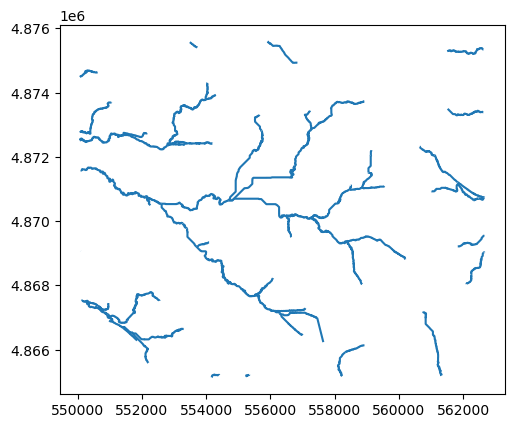

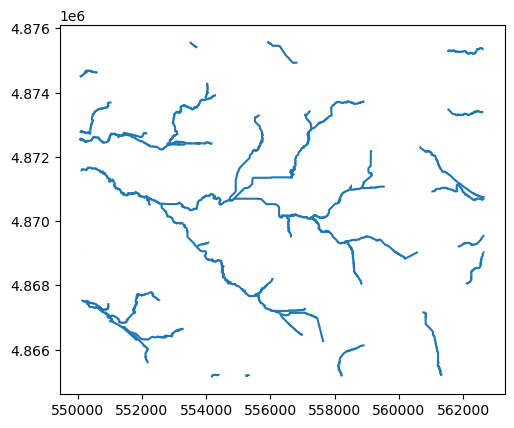

In [ ]:
import re
run = Config('EPM_2layer.yaml')
run.load_polygon('watershed', 'springshed', 'subdomain')
run.merge_polygons('merged', 'watershed_polygon', 'springshed_polygon')
run.load_creeks()
run.set_domain('subdomain_polygon')
run.apply_DEM_to_domain()
start = run.creeks.return_coordinates(186)[-1]
nearest = get_nearest_point(start, run.merged_polygon)
run.creeks.extend_creek(start, nearest)
start = run.creeks.return_coordinates(154)[-1]
nearest = get_nearest_point(start, run.merged_polygon)
run.creeks.extend_creek(start, nearest)
run.creeks.clip_creek(run.domain, 10)
run.load_karst_features()
run.extract_grid_params_from_domain()
run.extract_top_config()
run.extract_bottom_config()
run.create_grid()
run.extract_idomain()
run.extract_creek_cells()

mrsw = CalibrationData(name = 'mrsw', filename = '../../data/MRSW/MRSW_head_CSV.csv', UTME = 557091, UTMN = 4867265)
bs_q = CalibrationData(name = 'bs_q', filename = '../../data/discharge/discharge_2017_2020.csv')

mrsw.convert_data_to_timeseries()
bs_q.convert_data_to_timeseries(datetime_col='date')

mrsw.set_cal_value(mrsw.data['gw_elev[m]'].mean())
bs_q.set_cal_value(bs_q.data.rolling(window = '7D').mean().mean()['Q [m3/s]'])

mrsw_cell_idx = run.get_cell_id_from_coords(mrsw.UTME, mrsw.UTMN)
bs_UTME, bs_UTMN = run.spring[run.spring.ID == '55A00572'].UTME, run.spring[run.spring.ID == '55A00572'].UTMN
bs_cell_idx = run.get_cell_id_from_coords(bs_UTME, bs_UTMN)


In [8]:

pattern = r"creeks_([\d.]+)_springs_([\d.]+)_Kh_([\d.]+)_([\d.]+)_Kv_([\d.]+)_([\d.]+)"
run_data = pd.DataFrame(columns = keys + ['mrsw_head', 'mrsw_error', 'bs_q', 'bs_error', 'head_above_surface_error'])


In [10]:

for f in os.listdir('model_runs/EPM_2layer'):
    match = re.match(pattern, f)
    if match:
        result = {
            'C_creek': float(match.group(1)),
            'C_spring': float(match.group(2)),
            'Kh_0': float(match.group(3)), 
            'Kh_1' : float(match.group(4)),
            'Kv_0': float(match.group(5)),
            'Kv_1' : float(match.group(6))
        }
    try:
        run.load_sim(ws = f'model_runs/EPM_2layer/{f}')
    except:
        print(f'{f} not found, skipping')
        continue
    run.load_model()
    run.read_head_output()
    run.read_drain_discharge_output()
    result['mrsw_head'] = run.heads[0][mrsw_cell_idx]
    result['mrsw_error'] = mrsw.get_residual(result['mrsw_head'])
    result['bs_q'] = run.drain_array[0][bs_cell_idx]
    result['bs_error'] = bs_q.get_residual(result['bs_q'])
    result['head_above_surface_error'] = run.check_head_above_land_surface(return_type = 'count')
    run_data = pd.concat([run_data, pd.DataFrame(result)], axis = 0, ignore_index = True)




loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package rch...
    loading package drn...
  loading solution package epm_steady_state...
simulation model_runs/EPM_2layer/creeks_0.2_springs_10_Kh_10_1.0_Kv_0.1_0.1 loaded
model EPM_steady_state loaded
heads data read to heads
read drain discharge to drain_spd and drain_array
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...


C:\Users\huan1428\AppData\Local\Temp\ipykernel_15516\3546477783.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  run_data = pd.concat([run_data, pd.DataFrame(result)], axis = 0, ignore_index = True)


    loading package ic...
    loading package oc...
    loading package npf...
    loading package rch...
    loading package drn...
  loading solution package epm_steady_state...
simulation model_runs/EPM_2layer/creeks_0.2_springs_10_Kh_10_1.0_Kv_0.2_0.1 loaded
model EPM_steady_state loaded
heads data read to heads
read drain discharge to drain_spd and drain_array
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loading package dis...
    loading package ic...
    loading package oc...
    loading package npf...
    loading package rch...
    loading package drn...
  loading solution package epm_steady_state...
simulation model_runs/EPM_2layer/creeks_0.2_springs_10_Kh_10_1.0_Kv_0.30000000000000004_0.1 loaded
model EPM_steady_state loaded
heads data read to heads
read drain discharge to drain_spd and drain_array
loading simulation...
  loading simulation name file...
  loading tdis package...
  loading model gwf6...
    loadi

In [11]:
run_data

,Kh_0,Kh_1,Kv_0,Kv_1,C_spring,C_creek,mrsw_head,mrsw_error,bs_q,bs_error,head_above_surface_error
0,10.0,1.0,0.1,0.1,10.0,0.2,430.690680,84.950925,-470.986263,-471.052597,752027
1,10.0,1.0,0.2,0.1,10.0,0.2,430.690815,84.951060,-471.082820,-471.149154,752027
2,10.0,1.0,0.3,0.1,10.0,0.2,430.723037,84.983282,-471.427736,-471.494070,752027
3,10.0,1.0,0.4,0.1,10.0,0.2,430.689812,84.950057,-471.152867,-471.219201,752027
4,10.0,1.0,0.5,0.1,10.0,0.2,430.750717,85.010962,-471.663020,-471.729354,752027
5,10.0,1.0,0.6,0.1,10.0,0.2,430.692411,84.952656,-471.208202,-471.274536,752027
6,10.0,1.0,0.7,0.1,10.0,0.2,430.755029,85.015273,-471.709448,-471.775782,752027
7,10.0,1.0,0.8,0.1,10.0,0.2,430.747414,85.007659,-471.665793,-471.732127,752027
8,10.0,1.0,0.9,0.1,10.0,0.2,430.701011,84.961256,-471.183865,-471.250199,752027
9,10.0,1.0,1.0,0.1,10.0,0.2,430.747096,85.007341,-471.620912,-471.687246,752027


<Axes: xlabel='C_spring', ylabel='Kh_0'>

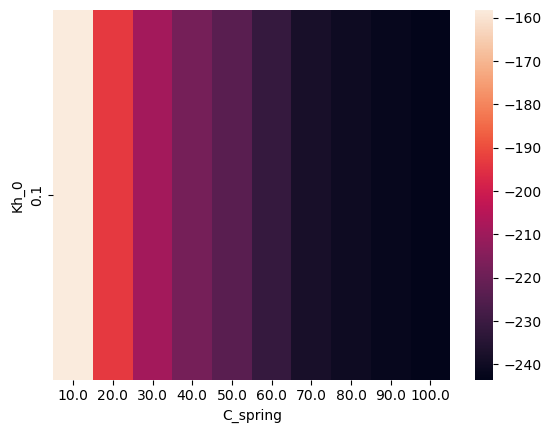

In [108]:
sns.heatmap(run_data[['Kh_0', 'C_spring', 'bs_error']].drop_duplicates().dropna().pivot_table(index = 'Kh_0', columns = 'C_spring', values = 'bs_error'))

## Charlie's stuff

In [59]:
%%time

# load the output from the simulation
head = gwf.output.head().get_alldata()
bud = gwf.output.budget()
spdis = bud.get_data(text='DATA-SPDIS')[0]
qx, qy, qz = flopy.utils.postprocessing.get_specific_discharge(spdis, gwf)

CPU times: user 36.9 ms, sys: 37.5 ms, total: 74.4 ms
Wall time: 141 ms


CPU times: user 43.3 s, sys: 904 ms, total: 44.2 s
Wall time: 44.4 s


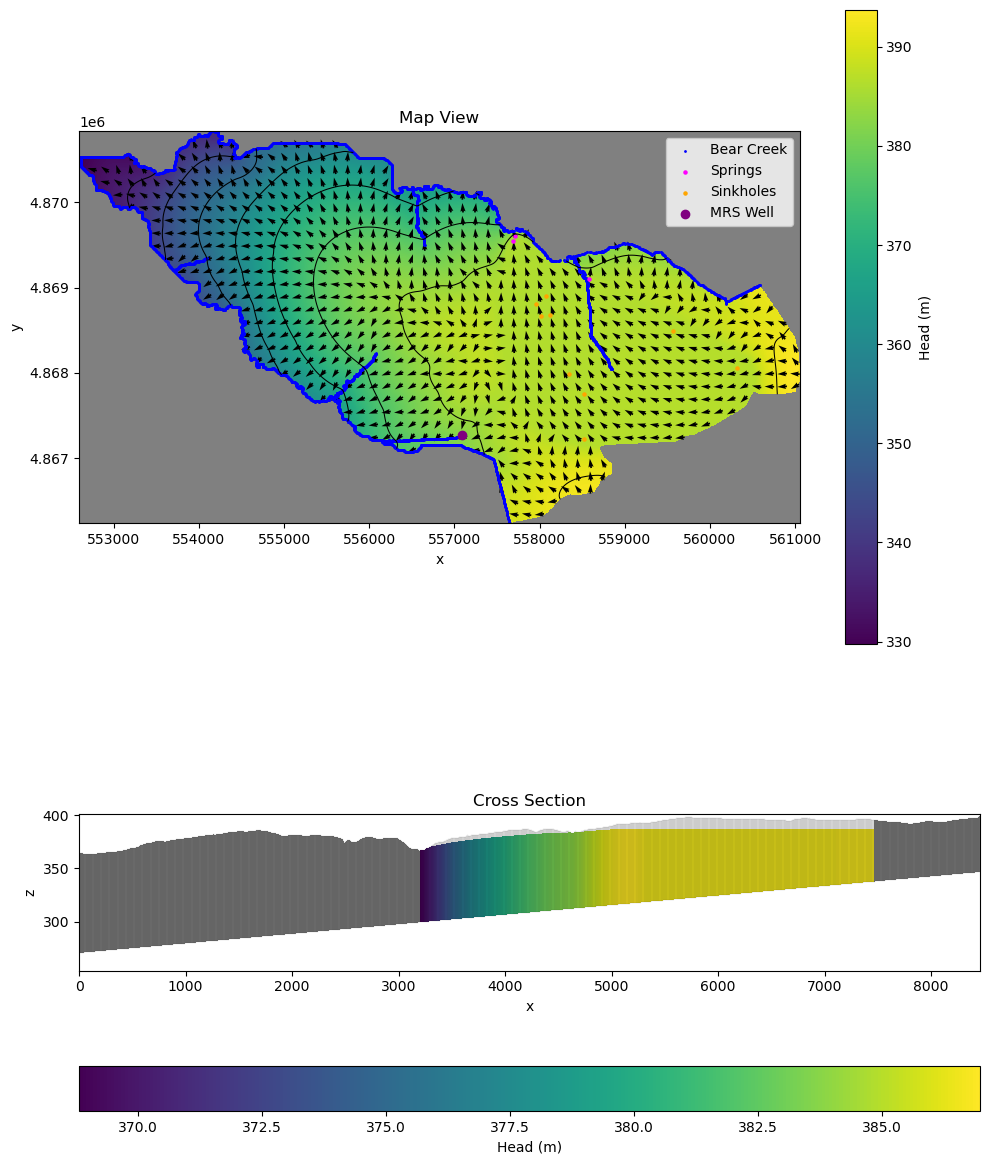

In [60]:
%%time

# create a plot of the model results
fig, axes = plt.subplots(2, 1, figsize=(10, 12))
ax = axes[0] 
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
max_head = np.max(head[head != 1e30]) #get the max head for the colorbar
min_head = np.min(head)
#pmv.plot_bc(ftype="CHD") 
cb = pmv.plot_array(head[0][0]) #plot the head at the start of the model
pmv.plot_inactive(color_noflow="gray")
#pmv.plot_grid(color="black", linewidth=0.1)
pmv.plot_vector(qx, qy, normalize=True, color="black", istep=30, jstep=30)
pmv.contour_array(head[0][0], colors='k', linewidths = 0.75)

plt.colorbar(cb, label = "Head (m)")

# Get cell locations for Bear Creek
river_cells = [(cell[1], cell[2]) for cell in all_creek_drains]  # Extract row and column indices from river_drain
river_x = [sg.xcellcenters[row, col] for row, col in river_cells] # Get x coordinates of river cells in the grid
river_y = [sg.ycellcenters[row, col] for row, col in river_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for Bear, Bear Overflow, and Hammel Springs
spring_x = [sg.xcellcenters[row, col] for name, elev, row, col in spring_cells] # Get x coordinates of river cells in the grid
spring_y = [sg.ycellcenters[row, col] for name, elev, row, col in spring_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for the Sinkholes in the model
#Get the cell locations for Bear, Bear Overflow, and Hammel Springs
sinkhole_x = [sg.xcellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get x coordinates of river cells in the grid
sinkhole_y = [sg.ycellcenters[row, col] for name, elev, row, col in sinkhole_cells] # Get y coordinates of river cells in the grid

#Get the cell locations for the MRS Well in the model: MRSW UTME: 557091, UTMN: 4867265
welli, wellj = sg.intersect(557091, 4867265)

#Get the water table elevation at the MRSW:
MRS_head = head[0][0][welli][wellj]

#Plot the creek, spring, and sinkhole cells on the map
ax.scatter(river_x, river_y, color='blue', s=1, label = 'Bear Creek') # PLot the river_drain cells
ax.scatter(spring_x, spring_y, color='magenta', s=5, label = 'Springs') # PLot the spring_drain cells
ax.scatter(sinkhole_x, sinkhole_y, color = 'orange', s=5, label = 'Sinkholes')

#Plot the location of the MRSW on the Plot
ax.scatter(557091, 4867265, color='purple', label = 'MRS Well')

ax.legend(loc = 'upper right')

#Temporarily disable cross section plotting while using highly discretized grid
ax = axes[1]
ax.set_title("Cross Section")
ax.set_aspect(10.)
ax.set_xlabel("x")
ax.set_ylabel("z")
pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": int(nrow*0.75)})
pxs.plot_inactive(color_noflow="gray")
#pxs.plot_bc(ftype="CHD")
pxs.plot_array(head, head=head)
cb = pxs.plot_array(head, head=head)
pxs.plot_grid(color="black", linewidth=0.05)
plt.colorbar(cb, orientation='horizontal', label = 'Head (m)')
plt.tight_layout()

## Check for Model Errors

CPU times: user 501 ms, sys: 6.96 ms, total: 507 ms
Wall time: 508 ms


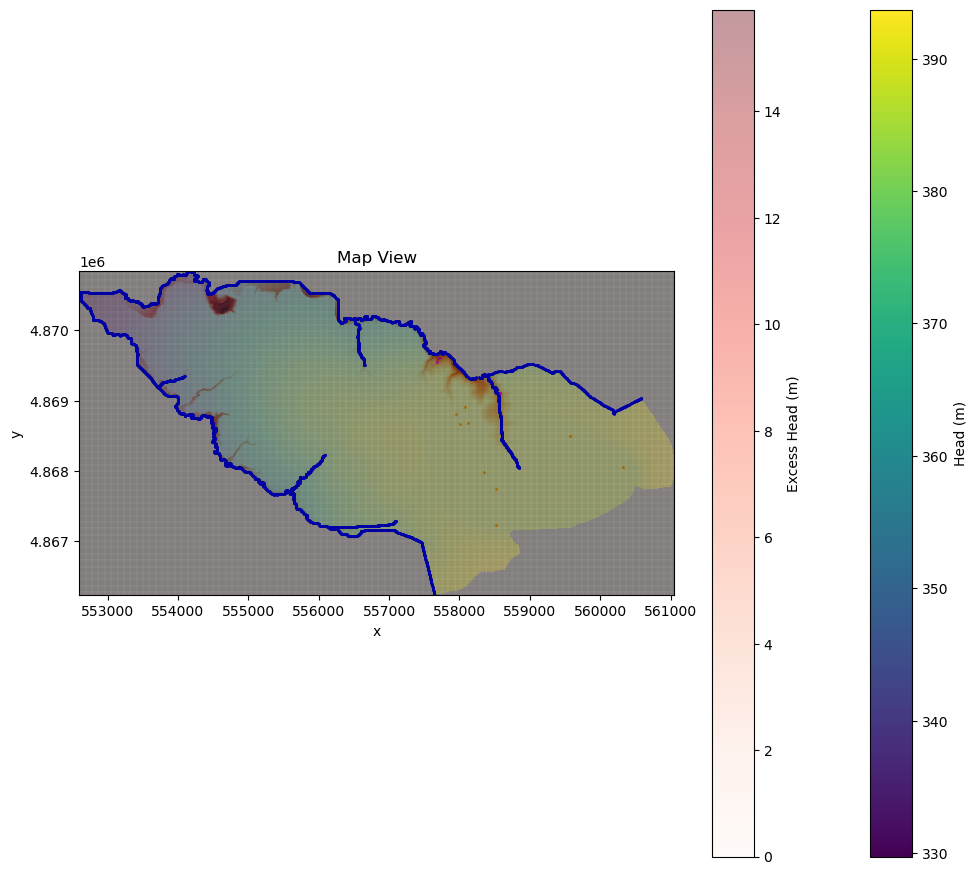

In [61]:
%%time

#Plot the locations where the hydraulic head exceeds the land surface elevation
excess_head_mask = np.zeros_like(head[0][0])
valid_mask = (head[0][0] < 1e30)  # Exclude cells with head >= 1e30
excess_head_mask[(head[0][0] > top) & valid_mask] = 1  # Mark cells with valid excess head

# Create an array to store the head difference
head_difference = np.zeros_like(excess_head_mask)  # Initialize with zeros (or np.nan if preferred)

# Record the head difference where the mask is active
head_difference = head[0][0] - top

head_difference[excess_head_mask == 0 ] = 0

# Plot the model results
fig, axes = plt.subplots(1, 1, figsize=(12, 11))
ax = axes
ax.set_title("Map View")
ax.set_aspect(1)
ax.set_xlabel("x")
ax.set_ylabel("y")

# Map view plot
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
cb = pmv.plot_array(head[0][0])  # Plot the head at the start of the model
pmv.plot_inactive(color_noflow="gray")
pmv.plot_grid(color="black", linewidth=0.05)

# Overlay the excess head mask
#pmv.plot_array(excess_head_mask, cmap="Reds", alpha=0.5, label="Excess Head")
cbx = pmv.plot_array(head_difference, cmap = "Reds", alpha = 0.4, label = "Excess Head")

# Plot features
ax.scatter(river_x, river_y, color='blue', s=1, label='Bear Creek')
ax.scatter(spring_x, spring_y, color='magenta', s=1, label='Springs')
ax.scatter(sinkhole_x, sinkhole_y, color='orange', s=1, label='Sinkholes')
#ax.legend(loc='upper right')

plt.colorbar(cb, label="Head (m)")
plt.colorbar(cbx, label = "Excess Head (m)")

# # Cross-section plot
# ax = axes[1]
# ax.set_title("Cross Section")
# ax.set_aspect(10.)
# ax.set_xlabel("y")
# ax.set_ylabel("z")

# pxs = flopy.plot.PlotCrossSection(gwf, ax=ax, line={"row": int(ncol / 2)})
# pxs.plot_inactive(color_noflow="gray")
# pxs.plot_array(head, head=head)
# cb = pxs.plot_array(head, head=head)
# pxs.plot_grid(color="black", linewidth=0.5)
# plt.colorbar(cb, orientation="horizontal", label="Head (m)")

# # Tight layout for plots
# plt.tight_layout()

In [62]:
#Setup for undoing the linear indexing used to assign values to the drian cells

linear_index = 4158

k = linear_index // (nrow * ncol)  # Calculate the layer index
i = (linear_index % (nrow * ncol)) // ncol  # Calculate the row index
j = linear_index % ncol  # Calculate the column index

print(k, i, j)

0 2 774


In [63]:
#Calculate the discharge from Bear Spring

#Get the Bear Spring Coordinates
print(f'The Coordinates for Bear Spring are:{kBS, iBS, jBS}')

#get the discharge from the BS drain and River drains
cbb_file = f"{ws}/{name}.bud"
cbb = flopy.utils.CellBudgetFile(cbb_file)

#Get all of the drain data from the cbb
drn_discharge = cbb.get_data(text='DRN') #retrieve all of the DRN flows

disch_array = np.array(drn_discharge) #convert the nested array to a format where it can actually be read

#calculate the total discharge through bear spring over the entire model, units of L**3
BS_m3 = 0
for i in range(len(disch_array[:,0])): #Bear Spring is the 0th index in the drn_array
    BS_m3 = BS_m3 + disch_array[:,0][i][2] * -1
#BS_m3 = BS_m3 / 24 # ONLY RELEVANT FOR TRANSIENT MODEL #convert to the correct units to account for the hourly tsteps (raw values given in m3/day, but the # of tsteps is hourly)
print(f"Total Bear Spring Discharge: {BS_m3:.0f} m³")

#Bear Creek Drain Cells total discharge
BC_m3 = 0 #Initialize the total discharge sum

# Loop over all timesteps (720 timesteps)
for i in range(np.shape(disch_array)[0]):  # Iterate over timesteps (rows of drn_array)
    # Loop over all drains, skipping the 0th drain
    for n in range(1, np.shape(disch_array)[1]):  # Start at n=1 to skip the 0th drain
        # Access the discharge value (3rd element of the tuple)
        BC_m3 += abs(disch_array[i, n][2])  # Add the absolute discharge value
        
#BC_m3 = BC_m3 / 24 #ONLY RELEVANT FOR TRANSIENT MODEL #convert to the correct units to account for the hourly tsteps (raw values given in m3/day, but the # of tsteps is hourly)   

# Print the total discharge in cubic meters (m³)
print(f"Total Bear Creek Discharge: {BC_m3:.0f} m³")
total_drain = BC_m3 + BS_m3
print(f"Total System Discharge: {total_drain:.0f} m³")

#Get the head value in the cell that is asssociated with the Galena MRS well to use as an additional calibration check point
print(f'The Water Table Elevation in the MRS well is: {MRS_head} m')
print(f'The Depth to water in the MRS well is: {top[welli][wellj]-MRS_head}')

The Coordinates for Bear Spring are:(0, 246, 1023)
Total Bear Spring Discharge: 5328 m³
Total Bear Creek Discharge: 16730 m³
Total System Discharge: 22057 m³
The Water Table Elevation in the MRS well is: 382.20163557568316 m
The Depth to water in the MRS well is: -0.011450028808155821


In [64]:
#Temporarily stop running the code to prevent running the sensitivity analysis code below
raise SystemExit("Paused for Results Evaluation")

SystemExit: Paused for Results Evaluation

/users/1/souce015/.conda/envs/modflow6_HPC/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3406: UserWarning: To exit: use 'exit', 'quit', or Ctrl-D.
  warn("To exit: use 'exit', 'quit', or Ctrl-D.", stacklevel=1)


### Run a sensitivity analysis for KhBPP

In [ ]:
# Define ranges for sensitivity analysis
KhBPP_values = np.linspace(1000, 10000, 20)  # 10 values between 1000 and 10000

# Initialize arrays to store results
BS_discharge_results = []
BC_discharge_results = []

#Predefine the locations where KhBPP is to limit run time
BPP_cells = np.where(K11 == KhBPP)

#Prepare the empty dataframes to accept the BC and BS discharge values
BS_discharge_results = []
BC_discharge_results = []
# Loop over parameter combinations
for KhBPP in KhBPP_values:

    print(f"Running simulation for KhBPP={KhBPP}")

    # Update hydraulic conductivity values
    K11 = Kh * np.ones((nlay, nrow, ncol))
    K33 = Kv * np.ones((nlay, nrow, ncol))

    #for i in range(len(BPP_cells[0])):
     #   row = BPP_cells[1][i] 
      #  col = BPP_cells[2][i]
       # K11[0, row, col] = KhBPP
    
    rows, cols = BPP_cells[1], BPP_cells[2]
    K11[0, rows, cols] = KhBPP
    
    # Update MODFLOW model with new parameters
    npf = flopy.mf6.ModflowGwfnpf(
        gwf,
        k=K11,
        k33=K33,
        icelltype=0,
        save_specific_discharge=True
    )

    # Run the simulation
    sim.write_simulation(silent=True)
    success, _ = sim.run_simulation(silent=True)
    if not success:
        print(f"Simulation failed for KhBPP={KhBPP}")
        BS_discharge_results.append(np.nan)
        BC_discharge_results.append(np.nan)
        continue

    # Extract discharge results
    cbb = flopy.utils.CellBudgetFile(f"{ws}/{name}.bud")
    drn_discharge = cbb.get_data(text='DRN')
    disch_array = np.array(drn_discharge)

    # Calculate Bear Spring discharge
    #BS_m3 = sum(d[:, 2] * -1 for d in disch_array[:, 0])

    # Calculate Bear Creek discharge
    #BC_m3 = sum(abs(d[:, 2]) for d in disch_array[:, 1:])

    # Calculate discharges
    #calculate the total discharge through bear spring over the entire model, units of L**3
    BS_m3 = 0
    for i in range(len(disch_array[:,0])): #Bear Spring is the 0th index in the drn_array
        BS_m3 = BS_m3 + disch_array[:,0][i][2] * -1
    
    #Bear Creek Drain Cells total discharge
    BC_m3 = 0 #Initialize the total discharge sum

    # Loop over all timesteps (720 timesteps)
    for i in range(np.shape(disch_array)[0]):  # Iterate over timesteps (rows of drn_array)
        # Loop over all drains, skipping the 0th drain
        for n in range(1, np.shape(disch_array)[1]):  # Start at n=1 to skip the 0th drain
            # Access the discharge value (3rd element of the tuple)
            BC_m3 += abs(disch_array[i, n][2])  # Add the absolute discharge value
    
    # Store results
    BS_discharge_results.append(BS_m3)
    BC_discharge_results.append(BC_m3)

# Plot results
fig, ax = plt.subplots(2, 1, figsize=(10, 8))

# Spring discharge
ax[0].plot(KhBPP_values, BS_discharge_results[:len(KhBPP_values)], marker='o', label='Bear Spring')
ax[0].set_title("Spring Discharge Sensitivity")
ax[0].set_xlabel("KhBPP (m/day)")
ax[0].set_ylabel("Discharge (m³)")
ax[0].legend()

# Creek discharge
ax[1].plot(KhBPP_values, BC_discharge_results[:len(KhBPP_values)], marker='o', label='Bear Creek')
ax[1].set_title("Creek Discharge Sensitivity")
ax[1].set_xlabel("KhBPP (m/day)")
ax[1].set_ylabel("Discharge (m³)")
ax[1].legend()

plt.tight_layout()
plt.show()


## Implement MODPATH particle tracking at Bear Spring

In [ ]:
%%time
#Forward Particle Tracking

#Generate MODPATH files
mpnamf = f"{name}_mp_forward"

#Generate the modpath7 object
mp = flopy.modpath.Modpath7(
    modelname = mpnamf,
    flowmodel = gwf,
    model_ws = ws
) 


#Generate list for particle Data storge
p = [(0, i, j) for i in range(nrow) for j in range(ncol) if idomain[0, i, j] > 0]

#Generate particle data
p = flopy.modpath.ParticleData(p, structured = True)

#Generate A particle Group object
pg = flopy.modpath.ParticleGroup(particledata = p)

#Set particle data to recharge and drain along the top cell face
defaultiface = {"RECHARGE": 6,"DRAIN": 6}
porosity = 0.066 #Calculated Field Scale Porosity (MGS Pump Testing)
mpbas = flopy.modpath.Modpath7Bas(
    mp,
    porosity = porosity,
    defaultiface = defaultiface
)

#Create the simulation object for the modpath7 object
mpsim = flopy.modpath.Modpath7Sim(
    mp,
    simulationtype = "pathline",
    pathlinefilename = f'mp.pathline7',
    endpointfilename=f"mp.endpoint7",
    trackingdirection="forward",
    # weaksinkoption="pass_through",
    weaksinkoption="stop_at",
    weaksourceoption="pass_through",
    budgetoutputoption="summary",
    referencetime=[0, 0, 0.0],
    stoptimeoption="extend",
    particlegroups=[pg],
    #zonedataoption="on",
    #stopzone=2,
    #zones=zone_array
)

mp.write_input()
mp.run_model()

In [ ]:
%%time
# Get all of the tracking pathline data and plot
#load forward tracking pathline data
fpth = pl.Path(ws) / f"mp.pathline7"

#Set the coordinates for the spring and for the creek
spring_cell = (0, 24, 102)
node_spring = get_nodes([spring_cell])
#node_creek = 

p = flopy.utils.PathlineFile(fpth)
pw = p.get_destination_pathline_data(dest_cells = node_spring)
pall = p.get_alldata()

#Load forward tracking endpoint data
fpth = pl.Path(ws) / f'mp.endpoint7'

e = flopy.utils.EndpointFile(fpth)

#Get all endpoint data (epd)
all_epd = e.get_alldata()

#Get particles that terminate in wells
spr_epd = e.get_destination_endpoint_data(dest_cells = node_spring)

#Get particles that terminate in creek boundaries
#riv_epd = e.get_destination_endpoint_data(dest_cells=node_creek)

#Plot the pathline data
fig, axes = plt.subplots(ncols=1, nrows=2, sharey= True, figsize=(12,9))

ax = axes[0]
mm = flopy.plot.PlotMapView(model = gwf, ax = ax)
mm.plot_grid(lw = 0.5)
mm.plot_pathline(pw, layer = 0, colors = 'red', lw = 0.05)
pmv = flopy.plot.PlotMapView(gwf, ax=ax)
#cb = pmv.plot_array(head[0][0])  # Plot the head at the start of the model
pmv.plot_inactive(color_noflow="gray")
#Plot features
ax.scatter(river_x, river_y, color='blue', s=1, label='Bear Creek')
ax.scatter(spring_x, spring_y, color='magenta', s=1, label='Springs')
ax.scatter(sinkhole_x, sinkhole_y, color='orange', s=1, label='Sinkholes')
ax.legend()

ax = axes[1]
mm = flopy.plot.PlotMapView(model = gwf, ax = ax)
mm.plot_grid(lw = 0.5)
mm.plot_endpoint(spr_epd, direction="starting", colorbar=True, shrink=0.5)
mm.plot_inactive(color_noflow="gray")
#Plot the features
ax.scatter(river_x, river_y, color='blue', s=1, label='Bear Creek')
ax.scatter(spring_x, spring_y, color='magenta', s=1, label='Springs')
ax.scatter(sinkhole_x, sinkhole_y, color='orange', s=1, label='Sinkholes')
ax.legend()

In [ ]:
print(f"Number of pathlines to spring: {len(pw)}")
print(f"Number of Cells that end at the spring {len(spr_epd)}")

In [ ]:
#Using Sinkhole 55D1312
node_source = get_nodes([(0, get_cell_elev('55D1208')[1], get_cell_elev('55D1208')[2])])
print(f'The Sinkhole node is: {node_source}')

In [ ]:
epd_df = pd.DataFrame.from_records(all_epd)
epd_df.head()
#stranded_particles = epd_df[epd_df['termination'] == 'INACTIVE']
epd_df['status']

In [ ]:
input_node = 7377  # Example input node value 55D1312
output_node = 4158  # Example output node value BearSpring

spr_epd_df = pd.DataFrame.from_records(spr_epd)
np.where(spr_epd_df['node0'] == input_node)
#spr_epd_df.head()
spr_epd_df.iloc[316]